# Projekt Eksploracji Danych Youtube Trending

## Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import multiprocessing as mp
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # To plot dates on histograms' axis
import itertools
from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
import stop_words
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
from sklearn.externals.joblib import Memory
memory = Memory(location='./joblib', verbose=0)

In [3]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')

## Wczytanie danych

In [4]:
data_gb = pd.read_csv("./youtube_data/GB_videos_5p.csv", sep=";")
data_us = pd.read_csv("./youtube_data/US_videos_5p.csv", sep=";")
data = pd.concat([data_gb, data_us])
del data_gb
del data_us
data.reset_index(drop=True, inplace=True)

In [5]:
data.shape

(79816, 16)

Łącznie, dane z obu plików zawierają 79816 wierszy, z których każdy opisany jest za pomocą następujących atrybutów:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79816 entries, 0 to 79815
Data columns (total 16 columns):
video_id                  79816 non-null object
trending_date             79816 non-null object
title                     79816 non-null object
channel_title             79816 non-null object
category_id               3930 non-null float64
publish_time              79816 non-null object
tags                      79816 non-null object
views                     79816 non-null int64
likes                     79816 non-null int64
dislikes                  79816 non-null int64
comment_count             79816 non-null int64
thumbnail_link            79816 non-null object
comments_disabled         79816 non-null bool
ratings_disabled          79816 non-null bool
video_error_or_removed    79816 non-null bool
description               78634 non-null object
dtypes: bool(3), float64(1), int64(4), object(8)
memory usage: 8.1+ MB


Przykładowe dane:

In [7]:
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,NaN,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,NaN,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


## Analiza atrybutów

In [8]:
def plot_dist_log(data, title=''):
    ax = sns.distplot(data);
    ax.set_yscale('log')
    ax.set_title(title)

### video_id

In [9]:
data.video_id.value_counts()

#NAZWA?        725
8h--kFui1JA     65
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     60
              ... 
tCnbAAgfxH8      1
gtprpculjrQ      1
IbmvDn6I6sI      1
7DLKv39MLbg      1
x8eLIJAM58M      1
Name: video_id, Length: 8510, dtype: int64

Wśród danych 725 razy występuje `#NAZWA?`. Jest to błąd danych, który należy albo naprawić, albo usunąć wiersze z występującym błędem. Po przyjrzeniu się danym, można zauważyć, że dla każdego innego wiersza, wartość pola `video_id` występuje również w atrybucie `thumbnail_link` jako część linku do miniaturki filmu. Aby nie tracić danych, posłużono się tym atrybutem, wycinając ze ścieżki odpowiedni człon i zastąpiono nim błędne pole `video_id`.

In [10]:
def get_id(v_id, link):
    if v_id == "#NAZWA?":
        tokens = link.split('/')
        return tokens[-2]
    else: return v_id

In [11]:
data['video_id'] = data.apply(lambda row : get_id(row.video_id, row.thumbnail_link), axis = 1) 

In [12]:
data.to_csv("./youtube_data/videos_5p.csv", sep=";") # zapisujemy poprawione dane w celu późniejszego wykorzystania do komunikacji poprzez YT API

In [13]:
data.video_id.value_counts()

8h--kFui1JA    65
vjSohj-Iclc    62
VYOjWnS4cMY    61
l884wKofd54    60
5GHXEGz3PJg    59
               ..
wtTmLBfIiG4     1
0lbJHqAGpbA     1
UC34HrZhfPM     1
KtA3Wp8eNgA     1
5llHhbYjBwY     1
Name: video_id, Length: 8606, dtype: int64

Atrybut `video_id` jest identyfikatorem filmu w serwisie YouTube. Wśród wszystkich wpisów występuje tylko 8606 unikalnych identyfikatorów, co oznacza, że większość filmów utrzymywała się na liście Trending przez dłuższy czas.

### trending_date

In [14]:
data.trending_date = pd.to_datetime(data.trending_date, format="%y.%d.%m")

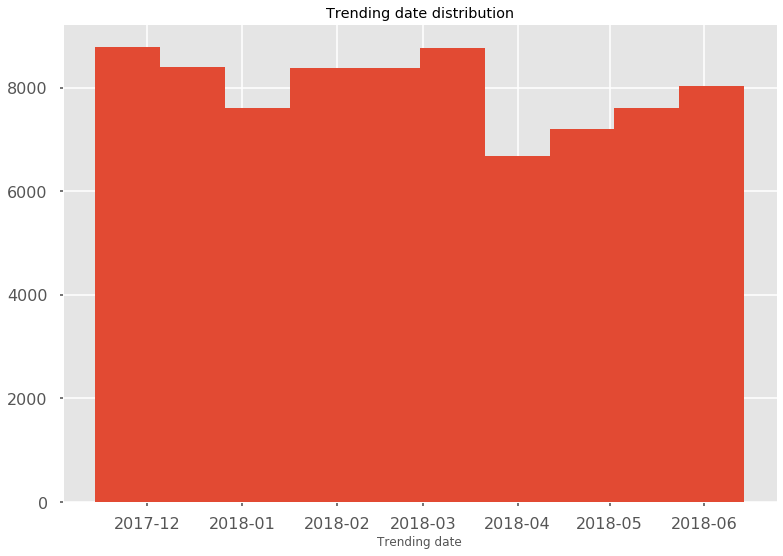

In [15]:
data.trending_date.hist()
plt.xlabel('Trending date')
plt.title('Trending date distribution');

In [16]:
data.publish_time.describe()

count                        79816
unique                        8465
top       2018-05-18T14:00:04.000Z
freq                            76
Name: publish_time, dtype: object

Filmy były _trending_ w okresach od listopada 2017 roku do czerwca 2018 roku i są rozłożone równomiernie.

### title

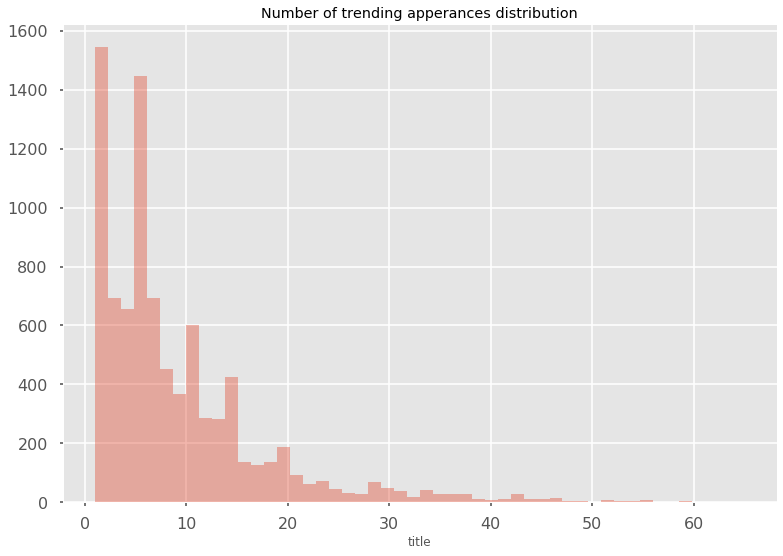

In [17]:
sns.distplot(data.title.value_counts(), kde=False);
plt.title('Number of trending apperances distribution');

Większość filmów była na liście Trending raz lub kilka razy, natomiast zdarzały się również takie, które utrzymywały się przez długi okres czasu.

### Channel title

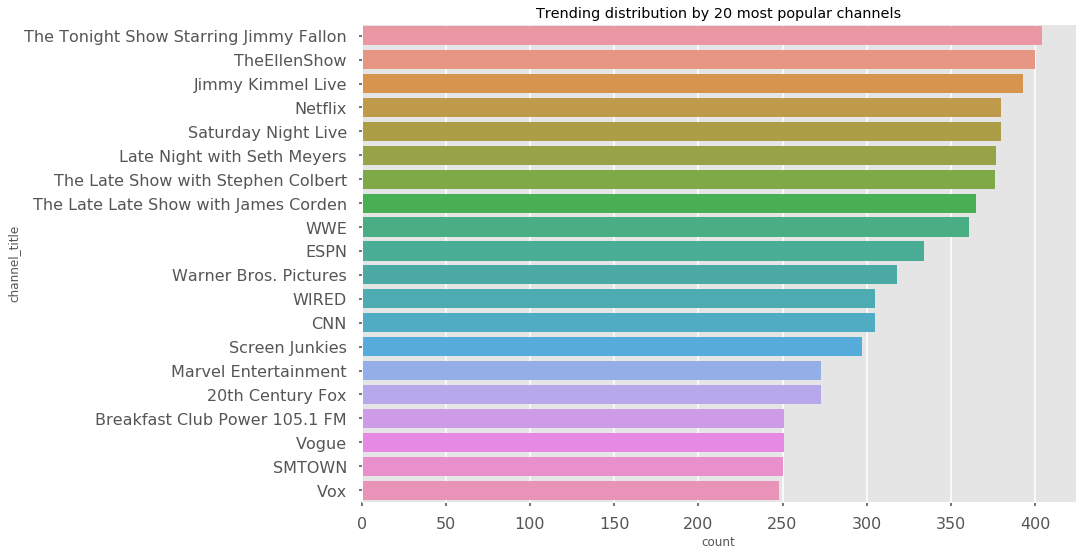

In [18]:
ax = sns.countplot(y='channel_title', data=data, order=data.channel_title.value_counts().iloc[:20].index, orient="h");
ax.set_title('Trending distribution by 20 most popular channels');

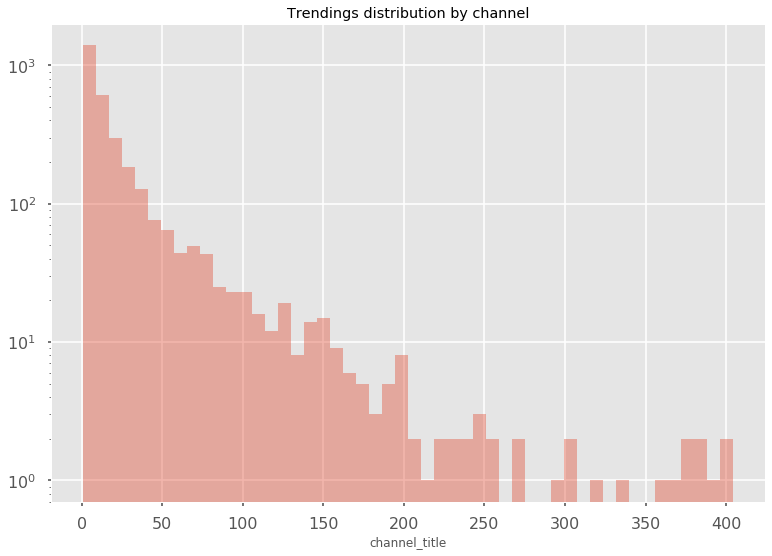

In [19]:
ax = sns.distplot(data.channel_title.value_counts(), kde=False);
ax.set_yscale('log');
ax.set_title('Trendings distribution by channel');

Niektóre kanały występują w danych znacznie częściej niż inne. Jest to spowodowane tym, że są to kanały znane globalnie, mające dużą ilość subskrybentów. Łatwiej im trafić do większej publiczności i zdobyć wysoką popularność filmów.

### category_id

In [20]:
data.category_id.value_counts(dropna=False)
data.category_id.isnull().sum()*100/len(data)

95.07617520296682

Nazwa kategorii jest pusta dla 95% przypadków. Jak wiemy z opisu ćwiczenia, uzupełnienie jej będzie jednym z zadań, dlatego na tym etapie pozostaje niezmieniona.

### publish_time

In [21]:
data.publish_time.head()
data.publish_time = pd.to_datetime(data.publish_time)

### Rok publikacji

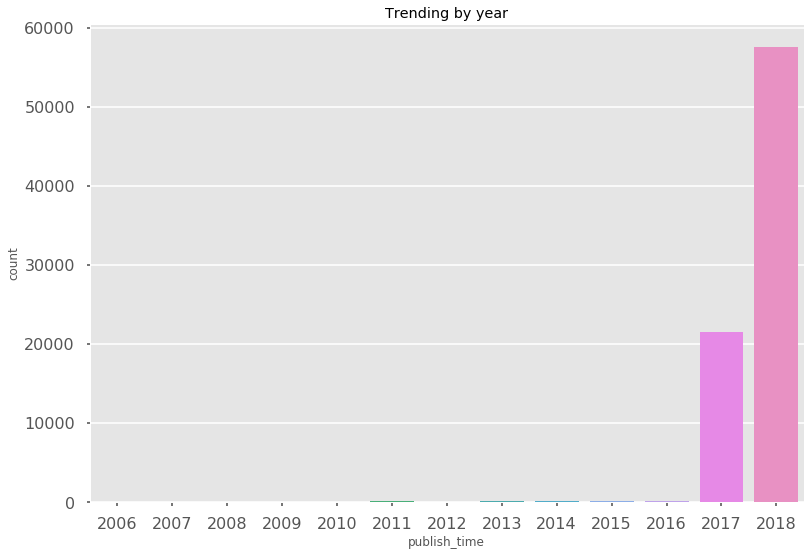

In [22]:
ax = sns.countplot(data.publish_time.dt.year);
ax.set_title('Trending by year');

Jak widać na wykresie przeważająca większosć filmów opublikowana została w roku 2018.  
Za istotny można uznać jeszcze rok 2017. Pozostałe ilości są pomijalne

#### Miesiąc publikacji

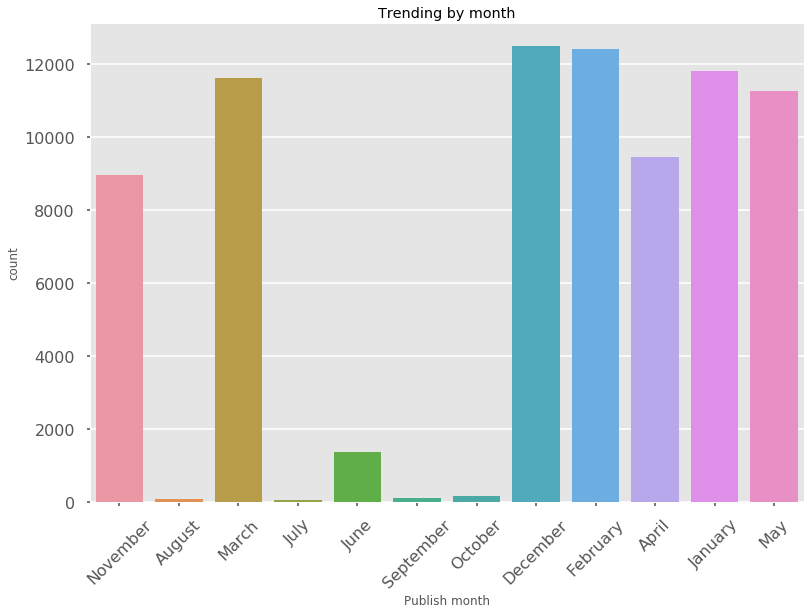

In [23]:
data["publish_month"] = data.publish_time.dt.month
sns.countplot(data.publish_time.dt.month_name())
plt.xticks(rotation=45)
plt.xlabel('Publish month');
plt.title('Trending by month');

### Czas publikacji

#### Godzina

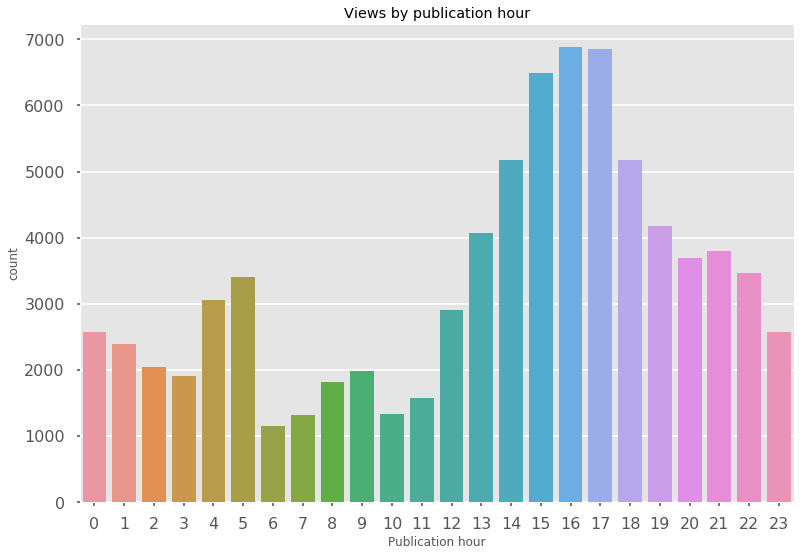

In [24]:
data["publish_hour"] = data.publish_time.dt.hour + data.publish_time.dt.minute/60
sns.countplot(data.publish_time.dt.hour)
plt.xlabel("Publication hour");
plt.title('Views by publication hour');

Na wykresie widać, iż szczyt publikacji przypada na godzinę 16 i 17.  
Widoczny jest też pik w okolicy godziny 5

#### Dzień

In [25]:
data["publish_day"] = data.publish_time.dt.weekday

In [26]:
days = data.publish_time.dt.day_name().unique()
print(days[[2,6,5,4,0,3,1]])

['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


Text(0.5, 1.0, 'Views by publish day')

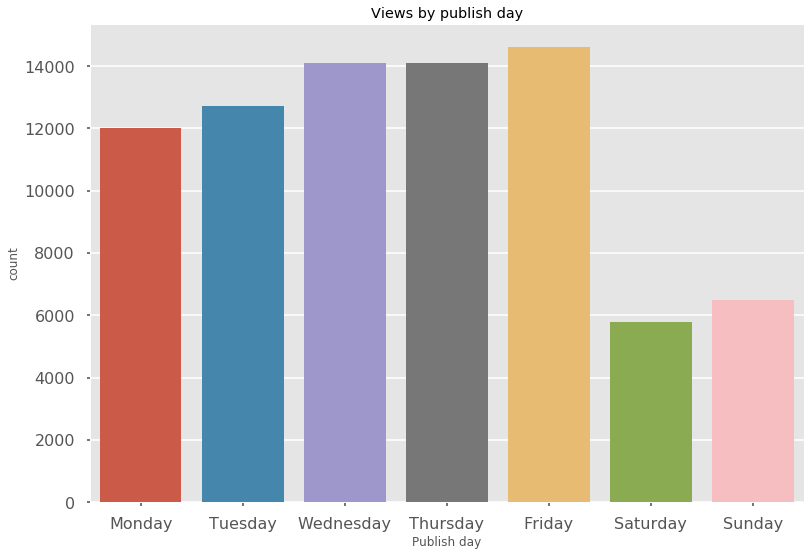

In [27]:
sns.countplot(data.publish_time.dt.day_name(), order=days[[2,6,5,4,0,3,1]])
plt.xlabel("Publish day");
plt.title('Views by publish day')

Większość filmów publikowana jest w ciągu tygodnia, w trakcie weekendu spada ilość publikacji

### Tags

In [28]:
data.tags.head()

0    christmas|"john lewis christmas"|"john lewis"|...
1    SNL|"Saturday Night Live"|"SNL Season 43"|"Epi...
2    Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
3    Salford City FC|"Salford City"|"Salford"|"Clas...
4                                               [none]
Name: tags, dtype: object

In [29]:
data.tags.values[0]

'christmas|"john lewis christmas"|"john lewis"|"christmas ad"|"mozthemonster"|"christmas 2017"|"christmas ad 2017"|"john lewis christmas advert"|"moz"'

In [30]:
data.tags.values[0].replace('"',"").split('|')

['christmas',
 'john lewis christmas',
 'john lewis',
 'christmas ad',
 'mozthemonster',
 'christmas 2017',
 'christmas ad 2017',
 'john lewis christmas advert',
 'moz']

In [31]:
def prepare_tags(tags):
    return tags.lower().replace('"', '').split('|') if tags != '[none]' else None

data['tags_split'] = data.tags.apply(prepare_tags)

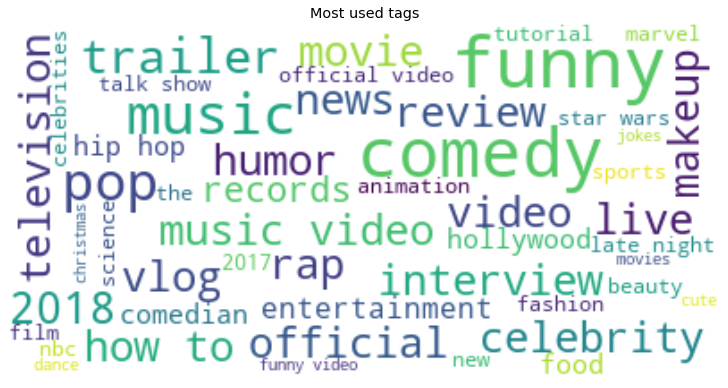

In [32]:
all_tags = [tags for tags in data.tags_split if tags != None]
all_tags = list(itertools.chain.from_iterable(all_tags))
tags100 = {a: b for a, b in Counter(all_tags).most_common(100)}
wordcloud = WordCloud(background_color='white',
                      max_words=50, 
                      max_font_size=40,
                      random_state=42).generate_from_frequencies(tags100)
plt.imshow(wordcloud, interpolation="bilinear")
plt.grid(b=None)
plt.axis("off")
plt.title("Most used tags");

Na powyższej grafice przedstawiono najczęściej występujące tagi. Większość z nich związana jest z rozrywką i spędzaniem czasu wolnego.

In [33]:
# Get top1000 tags for each month

tags_monthly = {}
all_top_monthly = {}

for i in range(1, 13):
    all_tags = [tags for tags in data.loc[data.publish_month==i, 'tags_split'] if tags != None]
    all_tags = list(itertools.chain.from_iterable(all_tags))
    tags = {a: b for a, b in Counter(all_tags).most_common(1000)}
    tags_monthly[i] = tags
    all_top_monthly[i] = list(tags.keys())

# Get unique ones from recieved tops
unique_monthly = [entry for entry, num in Counter(itertools.chain.from_iterable(all_top_monthly.values())).most_common() if num==1]

# Remove non-unique ones from each month's top1000
for month in tags_monthly:
    to_delete = []
    for tag in tags_monthly[month]:
        if not(tag in unique_monthly):
            to_delete.append(tag)
    for tag in to_delete:
        del tags_monthly[month][tag]

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate_from_frequencies(tup)
    return wordcloud

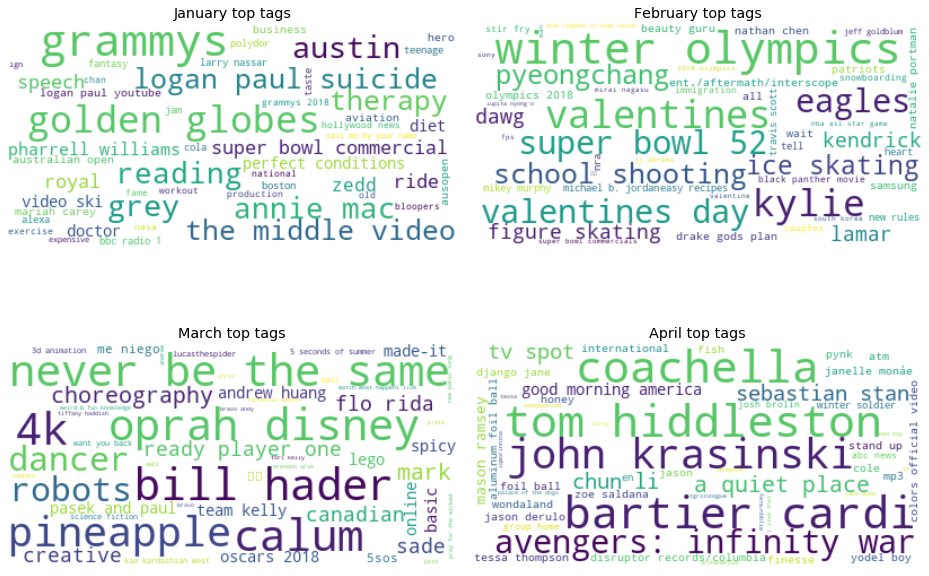

In [34]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[1]), interpolation="bilinear")
axs[0,0].title.set_text("January top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[2]), interpolation="bilinear")
axs[0,1].title.set_text("February top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[3]), interpolation="bilinear")
axs[1,0].title.set_text("March top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[4]), interpolation="bilinear")
axs[1,1].title.set_text("April top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

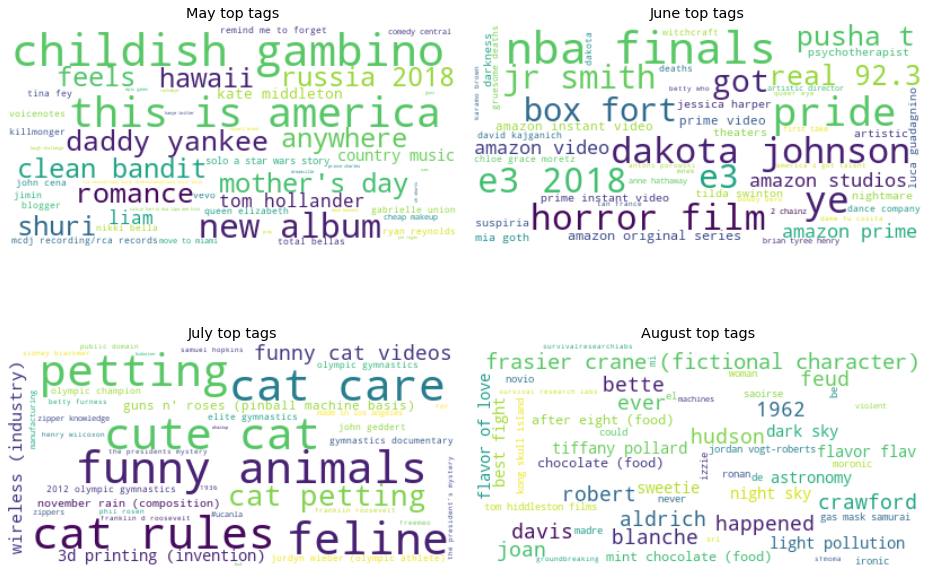

In [35]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[5]), interpolation="bilinear")
axs[0,0].title.set_text("May top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[6]), interpolation="bilinear")
axs[0,1].title.set_text("June top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[7]), interpolation="bilinear")
axs[1,0].title.set_text("July top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[8]), interpolation="bilinear")
axs[1,1].title.set_text("August top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

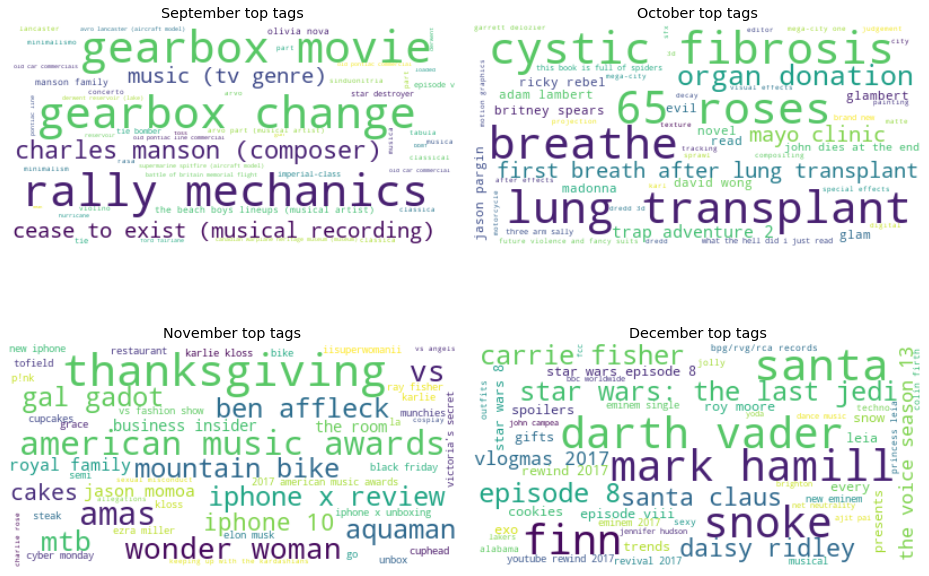

In [36]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[9]), interpolation="bilinear")
axs[0,0].title.set_text("September top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[10]), interpolation="bilinear")
axs[0,1].title.set_text("October top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[11]), interpolation="bilinear")
axs[1,0].title.set_text("November top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[12]), interpolation="bilinear")
axs[1,1].title.set_text("December top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

### Views

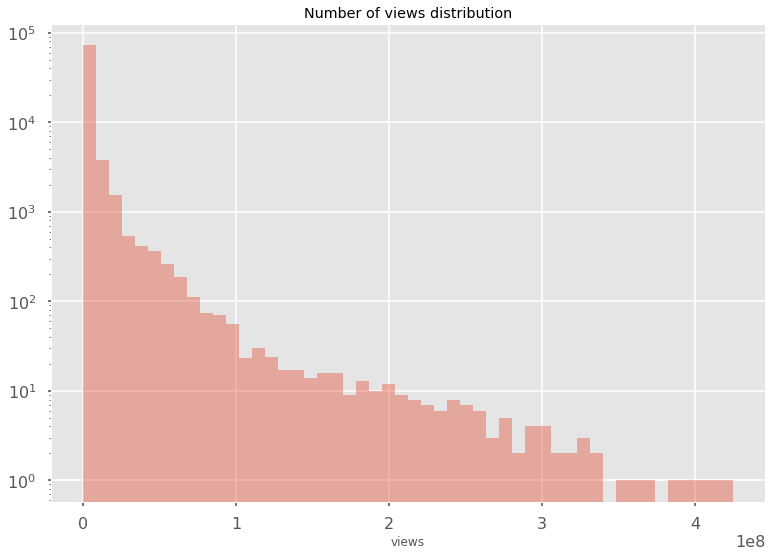

In [37]:
ax = sns.distplot(data.views, kde=False)
ax.set_yscale('log')
ax.set_title('Number of views distribution');

### Likes

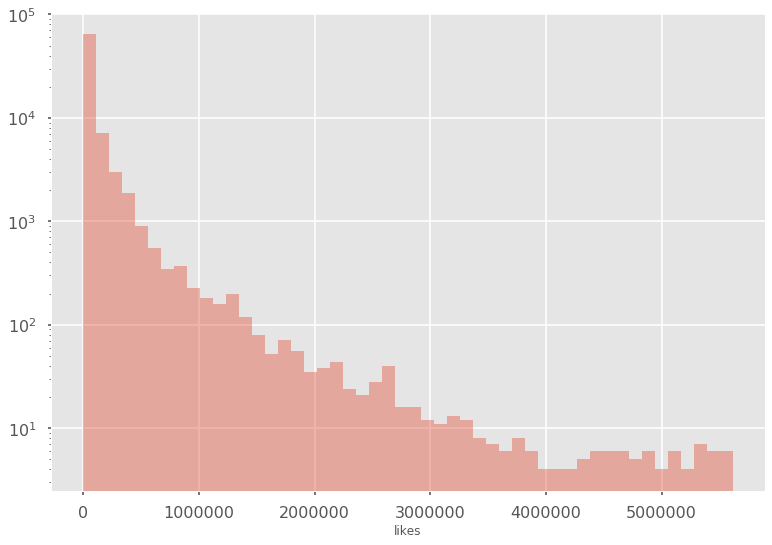

In [38]:
ax = sns.distplot(data.likes, kde=False);
ax.set_yscale('log');

### Dislikes

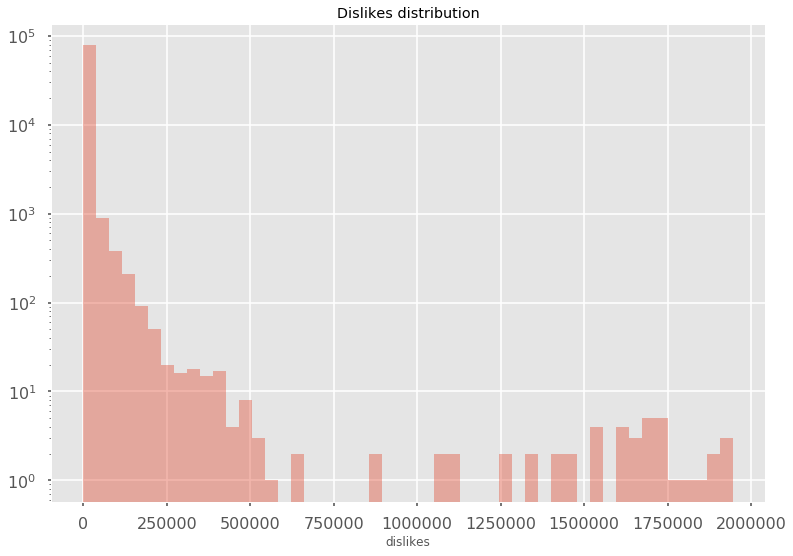

In [39]:
ax = sns.distplot(data.dislikes, kde=False)
ax.set_title('Dislikes distribution')
ax.set_yscale('log');

### Comment count

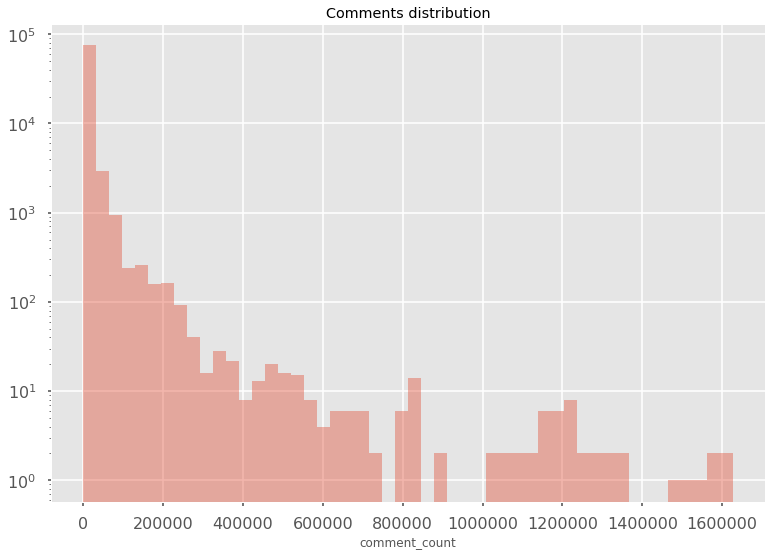

In [40]:
ax = sns.distplot(data.comment_count, kde=False);
ax.set_title('Comments distribution');
ax.set_yscale('log');

Liczba wyświetleń, poozytywnych i negatywnych reakcji a także liczba komentarzy mają rozkład skośny - w danych występuje mała liczba filmów o rekordowej oglądalności, wzbudzających bardzo dużo pozytywnych i negatywnych reakcji i komentarzy. Większość filmów jest do siebie zbliżona z globalnego punktu widzenia.

### Thumbnail_link

In [41]:
data.thumbnail_link.head()

0    https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
1    https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
2    https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
3    https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
4    https://i.ytimg.com/vi/rHwDegptbI4/default.jpg
Name: thumbnail_link, dtype: object

Wszystkie linki mają podobną strukturę: różnią się jedynie członem stanowiącym identyfikator filmu.

### comments_disabled

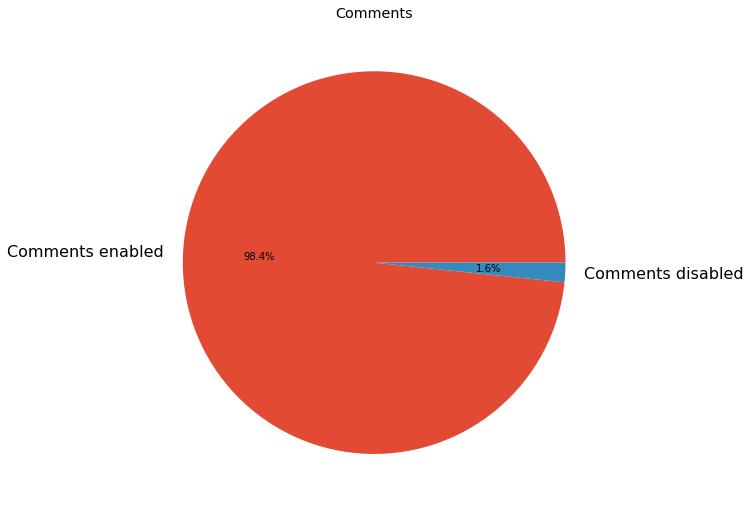

In [42]:
plt.pie(data.comments_disabled.value_counts()/data.comments_disabled.count(), 
        labels=["Comments enabled", "Comments disabled"], 
        autopct='%1.1f%%');
plt.title('Comments');

Filmy z wyłączoną możliwością komentowania stanowią jedynie 1,65% całego zbioru danych. W dalszej części projektu ciekawym zagadnieniem może okazać się analiza tych filmów - jakie były prawdopodobne powody wyłączenia komentarzy oraz jednoczesna wysoka popularność - może były to komunikaty rządowe, kontrowersyjne treści, a może jeszcze inne? 

### Rating disabled

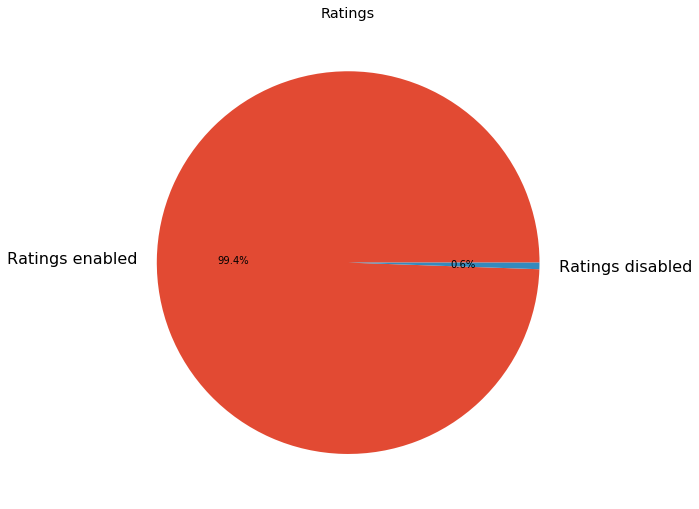

In [43]:
plt.pie(data.ratings_disabled.value_counts()/data.ratings_disabled.count(),
        labels=["Ratings enabled", "Ratings disabled"], 
        autopct='%1.1f%%');
plt.title('Ratings');

Filmy z wyłączoną możliwością oceniania stanowią 0,55% całego zbioru danych. Jak wyżej, analiza powodów takiej decyzji może być interesującym zagadnieniem.

### video_error_or_removed 

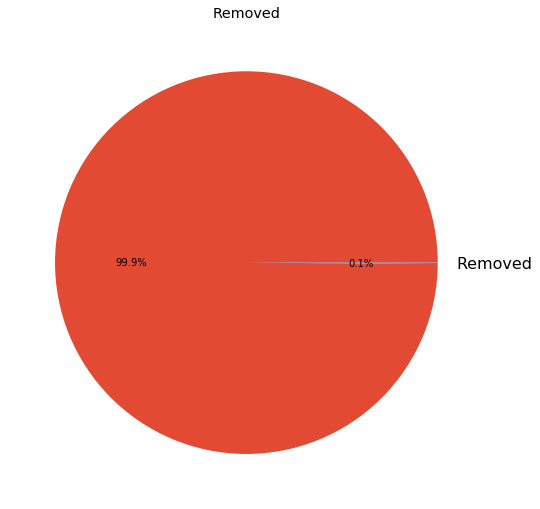

In [44]:
plt.pie(data.video_error_or_removed.value_counts()/data.video_error_or_removed.count(),
        labels=["", "Removed"], 
        autopct='%1.1f%%');
plt.title('Removed');

Filmy usunięte lub powodujące błędy stanowią 0,12% całego zbioru danych. Być może niektóre z nich zdobyły popularność ze względu wysokiej kontrowersyjności i zostały z tego samego powodu usunięte? Może łamały prawa autorskie? Przyjrzymy się im w kolejnym etapie analizy.

### description

In [45]:
data.columns = data.columns.str.replace('description ', 'description')

In [46]:
data.description.values[0]

"Click here to continue the story and make your own monster:\\nhttp://bit.ly/2mboXgj\\n\\nJoe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night’s sleep.\\n\\nShop the ad\\nhttp://bit.ly/2hg04Lc\\n\\nThe music is Golden Slumbers performed by elbow, the original song was by The Beatles. \\nFind the track:\\nhttps://Elbow.lnk.to/GoldenSlumbersXS\\n\\nSubscribe to this channel for regular video updates\\nhttp://bit.ly/2eU8MvW\\n\\nIf you want to hear more from John Lewis:\\n\\nLike John Lewis on Facebook\\nhttp://www.facebook.com/johnlewisretail\\n\\nFollow John Lewis on Twitter\\nhttp://twitter.com/johnlewisretail\\n\\nFollow John Lewis on Instagram\\nhttp://instagram.com/johnlewisretail"

## Wytworzenie atrybutów do predykcji

Dostępne atrybuty są mniej lub bardziej informatywne dla postawionego problemu. Na przykład można zastanowić się, czy liczba pozytywnych reakcji sprzyja wyższej oglądalności, jednak nie jest to czynnik, który autor filmu ma pod kontrolą. Niektóre z artybutów można poddać dodatkowym operacjom mającym na celu ekstrakcję cech, które będą przydatne w procesie odkrywania wiedzy. Do takich atrybutów należą na pewno: `title`, `tags`, `description`. Atrybuty takie jak: `comments_disabled`, `ratings_disabled`, `comment_count`, `video_error_or_removed`, `dislikes`, `publish_time` mogą częściowo wchodzić w korelacje z innymi atrybutami (np. można spodziewać się, że w okresie świątecznym w tagach będzie przeważało słowo "christmas", flaga `video_error_or_removed` może być w zależności z liczbą negatywnych reakcji itp.). Atrybutami, których nie będziemy analizować w tej części są: `video_id` - ze względu na to, że jest to unikalny identyfikator filmu, `views` - niemożność bezpośredniego wpływu, `category_id` - brak danych z wiadomych przyczyn.

Odnośnie dalszych działań to bym to widziała tak:
- Dla każdego z {title, tags, description}:
   
    - tokenizacja
    - usunięcie stopwords
    - (lematyzacja/stemming)
    - wytworzenie reprezentacji word2vec, tfidf, embeddings (nwm czy wszystkie, może tylko niektóre/jeden z nich albo inne)
    - ? może wytworzenie jakiegoś/jakichś binarnych atrybutów mówiących o tym, czy posiada słowa, które w danym czasie były najbardziej "na czasie" - tzn. na przykład w lipcu mamy, że najczęściej pojawiają się "science, independence, cat" i atrybut miałby True, jeśli dla tego filmu też występuję jedno z nich np. "science"  **Bardzo podoba mi się pomysł**
    - procentowa zawartość capital letters
    - obecność znaków typu emotikony, wykrzykniki, znaki zapytania itp.
    - długość całego tekstu
    
    
- sprawdzenie prawdopodobnych korelacji, o których pisałam wyżej
- Równolegle dobrze by było ogarnąć YouTube API i zacząć ściągać dane potrzebne do punktu 5

Propozycje atrybutów tekstowych:,
 * Czy występuje link / ilość linków,
 * Czy opis zawiera tagi / ilość tagów zawartych w opisie,
 * Ilość tagów,    
 * Czy zawarty jest link do FB / Instagrama / SnapChata / Twittera... (lub czy w ogóle do jakichś mediów społecznościowych),
 * Długość opisu,
 * NLP - Proponuję użyć Tf-Idf by mieć punkt wyjścia i jednej DLowej metody - ELMO lub BERT (ja mam doświadczenie z ELMO),
 
Atrybuty pozatekstowe:
  * Czy opublikowane w weekend,
  * Godzina publikacji (kodowanie atrybutu - ciekawy temat),
  * Czy jest muzyką? (pytanie jak sprawdzić?), **pewnie można po kategorii, której na razie nie mamy**
  * Czy komentarze wyłączone,
  * Czy rating wyłączony

In [47]:
def length(wordlist):
    if wordlist is None: return 0
    else: return len(wordlist)

def onlyalpha(string):
    return word_tokenize(''.join([char for char in string if char.isalpha() or char.isspace()]))

def count_capitals(alphalist):
    string = ''.join(alphalist)
    if len(string) == 0:
        return 0
    else: return len([char for char in string if char.isupper()])/ len(string)
    
def tokenize(column):
    if column is None:
        return []
    else:
        string = str(column)
        return word_tokenize(string)

def count_words(linklist, word):
    return ''.join(linklist).count(word)

### Atrybuty wytworzone z tytułu

Nowe atrybuty:
 * `title_num_words` - z ilu słów składa się tytuł (wykluczamy liczby) 
 * `title_capital` - procentowa zawartość wielkich liter
 * `title_exc_count` - liczba wykrzykników
 * `title_que_count` - liczba znaków zapytania

In [48]:
data['title_split'] = data.title.apply(word_tokenize)
data['title_alpha'] = data.title.apply(onlyalpha)
data['title_num_words'] = data.title_alpha.apply(length)
data['title_capital'] = data.title_alpha.apply(count_capitals)
data['title_exc_count'] = data.apply(lambda row: row['title'].count('!'), axis=1)
data['title_que_count'] = data.apply(lambda row: row['title'].count('?'), axis=1)

In [49]:
data[['video_id','title_split', 'title_alpha', 'title_num_words', 'title_capital', 'title_exc_count', 'title_que_count']].head(8)

,video_id,title_split,title_alpha,title_num_words,title_capital,title_exc_count,title_que_count
0,Jw1Y-zhQURU,"[John, Lewis, Christmas, Ad, 2017, -, #, MozTh...","[John, Lewis, Christmas, Ad, MozTheMonster]",5,0.212121,0,0
1,3s1rvMFUweQ,"[Taylor, Swift, :, …Ready, for, It, ?, (, Live...","[Taylor, Swift, Ready, for, It, Live, SNL]",7,0.285714,0,1
2,n1WpP7iowLc,"[Eminem, -, Walk, On, Water, (, Audio, ), ft.,...","[Eminem, Walk, On, Water, Audio, ft, Beyoncé]",7,0.193548,0,0
3,PUTEiSjKwJU,"[Goals, from, Salford, City, vs, Class, of, 92...","[Goals, from, Salford, City, vs, Class, of, an...",13,0.133333,1,0
4,rHwDegptbI4,"[Dashcam, captures, truck, 's, near, miss, wit...","[Dashcam, captures, trucks, near, miss, with, ...",9,0.043478,0,0
5,AumaWl0TNBo,"[How, My, Relationship, Started, !]","[How, My, Relationship, Started]",4,0.166667,1,0
6,2Vv-BfVoq4g,"[Ed, Sheeran, -, Perfect, (, Official, Music, ...","[Ed, Sheeran, Perfect, Official, Music, Video]",6,0.176471,0,0
7,-N5eucPMTTc,"[CHRISTMAS, HAS, GONE, TO, MY, HEAD]","[CHRISTMAS, HAS, GONE, TO, MY, HEAD]",6,1.000000,0,0


### Atrybuty wytworzone z tagów

#### Trending date vs publish date

In [50]:
data["trend_pub_date_diff"] = data.trending_date.dt.date - data.publish_time.dt.date
max(data.trending_date)
min(data.publish_time)

Timestamp('2006-07-23 08:24:11+0000', tz='UTC')

Nowe atrybuty:
 * `tags_count` - liczba tagów
 * `uses_previous_tags` - jaki odsetek spośród użytych tagów pojawił się w filmach trendujących w ciągu 30 dni od publikacji danego filmu

In [51]:
@memory.cache
def get_trending_30():
    has_tags = data.tags_split.values != None
    publish_dates = data.publish_time.apply(lambda x: x.date()).unique()
    trending_date_no_zone = data.trending_date.apply(lambda x: x.date())
    trending_30 = {}
    
    for date in publish_dates:
        diff = -(trending_date_no_zone - date)
        last_30 = diff <= datetime.timedelta(days=30)
        before = diff >= datetime.timedelta(days=0)
        tags_nested = data.loc[last_30 & before & has_tags, 'tags_split']
        trending_30[date] = set(itertools.chain.from_iterable(tags_nested))
    return trending_30

trending_30 = get_trending_30()

In [52]:
def uses_trending_30(row):
    if row.tags_split == None:
        return 0
    intersection = set(row.tags_split) & trending_30[row.publish_time.date()]
    return len(intersection)/len(row.tags_split)

In [53]:
@memory.cache
def get_uses_previous_tags():
    return data.apply(uses_trending_30, axis=1)

data["uses_previous_tags"] = get_uses_previous_tags()

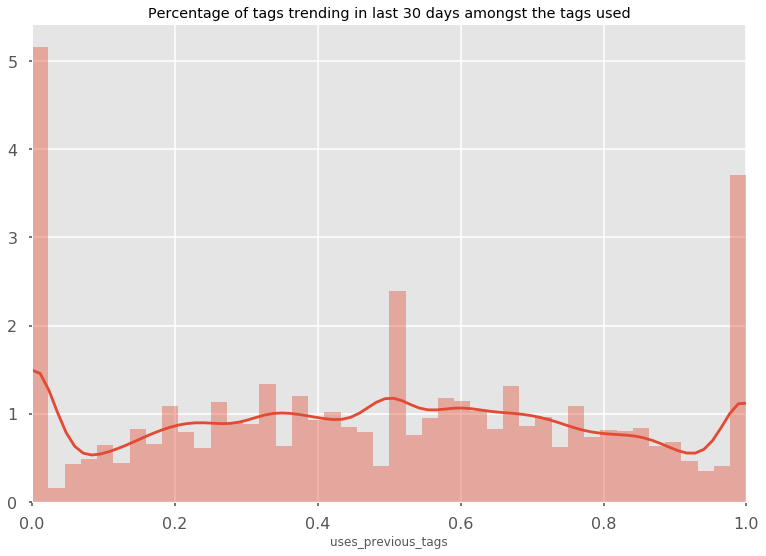

In [54]:
sns.distplot(data.uses_previous_tags).set_title('Percentage of tags trending in last 30 days amongst the tags used');
plt.xlim(0, 1);

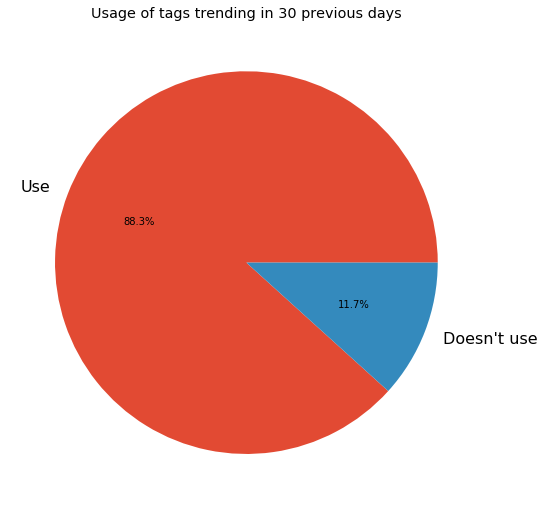

In [55]:
uses_previous_tags_bool = data.uses_previous_tags > 0
plt.pie(uses_previous_tags_bool.value_counts()/uses_previous_tags_bool.count(), 
        labels=["Use", "Doesn't use"], 
        autopct='%1.1f%%');
plt.title("Usage of tags trending in 30 previous days");
del uses_previous_tags_bool

Poniższej komórki nie usuwam, na wypadek gdybyśmy chcieli giedyś coś paralelizować

In [56]:
# @memory.cache
# def parallel_apply(df, func):
#     n_cores = mp.cpu_count()
#     df_split = np.array_split(df, n_cores)
#     pool = mp.Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

### Atrybuty wytworzone z opisu

Nowe atrybuty:
 * `desc_lines_count` - długość opisu w liniach
 * `desc_num_words` - długośc opisu w słowach
 * `links_count` - liczba linków w opisie
 * `fb_links`, `ig_links`, `tt_links`, `sc_links` - liczba linków do Facebooka, Instagrama, Twittera, SnapChata
 * `social_links` - suma powyższych

In [57]:
# Zródło: https://mail.python.org/pipermail/tutor/2002-September/017228.html

urls = '(?: %s)' % '|'.join("""http telnet gopher file wais ftp https""".split())
ltrs = r'\w'
gunk = r'/#~:.?+=&%@!\-'
punc = r'.:?\-'
any = "%(ltrs)s%(gunk)s%(punc)s" % { 'ltrs' : ltrs,
                                     'gunk' : gunk,
                                     'punc' : punc }

url = r"""
    \b                            # start at word boundary
        %(urls)s    :             # need resource and a colon
        [%(any)s]  +?             # followed by one or more
                                  #  of any valid character, but
                                  #  be conservative and take only
                                  #  what you need to....
    (?=                           # look-ahead non-consumptive assertion
            [%(punc)s]*           # either 0 or more punctuation
            (?:   [^%(any)s]      #  followed by a non-url char
                |                 #   or end of the string
                  $
            )
    )
    """ % {'urls' : urls,
           'any' : any,
           'punc' : punc }

url_re = re.compile(url, re.VERBOSE | re.MULTILINE)

def grabUrls(text):
    """Given a text string, returns all the urls we can find in it."""
    return url_re.findall(text)

In [58]:
@memory.cache
def get_desc_lines_count():
    return data.apply(lambda row: str(row['description']).count("\\n"), axis=1)

@memory.cache
def get_desc_clean():
    return data.apply(lambda row: str(row['description']).replace("\\n", " "), axis=1)

@memory.cache
def get_desc_split():
    return data.apply(lambda row: str(row['desc_clean']).split(" "), axis=1)
    
data['desc_lines_count'] = get_desc_lines_count()
data['desc_clean'] = get_desc_clean()
data['desc_split'] = get_desc_split()
data['desc_num_words'] = data.desc_split.apply(length)

In [59]:
@memory.cache
def get_links():
    return data.desc_clean.apply(grabUrls)

@memory.cache
def get_fb_links():
    return data.apply(lambda row: count_words(row['links'], 'facebook'), axis=1)

@memory.cache
def get_tt_links():
    return data.apply(lambda row: count_words(row['links'], 'twitter'), axis=1)

@memory.cache
def get_ig_links():
    return data.apply(lambda row: count_words(row['links'], 'instagram'), axis=1)

@memory.cache
def get_sc_links():
    return data.apply(lambda row: count_words(row['links'], 'snapchat'), axis=1)

data['links'] = get_links()
data['links_count'] = data.links.apply(len)
data['fb_links'] = get_fb_links()
data['tt_links'] = get_tt_links()
data['ig_links'] = get_ig_links()
data['sc_links'] = get_sc_links()
data['social_links'] = data.apply(lambda row: sum([row['fb_links'], row['tt_links'], row['ig_links'], row['sc_links']]), axis=1)

In [60]:
data[['video_id','description','desc_lines_count', 'desc_clean', 'desc_split', 'desc_num_words']].head(8)

,video_id,description,desc_lines_count,desc_clean,desc_split,desc_num_words
0,Jw1Y-zhQURU,Click here to continue the story and make your...,24,Click here to continue the story and make your...,"[Click, here, to, continue, the, story, and, m...",122
1,3s1rvMFUweQ,Musical guest Taylor Swift performs …Ready for...,11,Musical guest Taylor Swift performs …Ready for...,"[Musical, guest, Taylor, Swift, performs, …Rea...",40
2,n1WpP7iowLc,Eminem's new track Walk on Water ft. Beyoncé i...,17,Eminem's new track Walk on Water ft. Beyoncé i...,"[Eminem's, new, track, Walk, on, Water, ft., B...",51
3,PUTEiSjKwJU,Salford drew 4-4 against the Class of 92 and F...,7,Salford drew 4-4 against the Class of 92 and F...,"[Salford, drew, 4-4, against, the, Class, of, ...",44
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,4,Dashcam captures truck's near miss with child ...,"[Dashcam, captures, truck's, near, miss, with,...",26
5,AumaWl0TNBo,► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...,16,► HOW MY RELATIONSHIP STARTED! ► PB Merch • ht...,"[►, HOW, MY, RELATIONSHIP, STARTED!, ►, PB, Me...",59
6,2Vv-BfVoq4g,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,44,🎧: https://ad.gt/yt-perfect 💰: https://atlanti...,"[🎧:, https://ad.gt/yt-perfect, 💰:, https://atl...",162
7,-N5eucPMTTc,CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...,20,CHRISTMAS HAS GONE TO MY HEAD Previous Vlog: h...,"[CHRISTMAS, HAS, GONE, TO, MY, HEAD, Previous,...",99


In [61]:
data[['video_id', 'links', 'links_count', 'fb_links', 'tt_links', 'ig_links', 'sc_links', 'social_links']].head(8)

,video_id,links,links_count,fb_links,tt_links,ig_links,sc_links,social_links
0,Jw1Y-zhQURU,"[http://bit.ly/2mboXgj, http://bit.ly/2hg04Lc,...",7,1,1,1,0,3
1,3s1rvMFUweQ,"[http://www.nbc.com/saturday-night-live, http:...",7,1,1,1,0,3
2,n1WpP7iowLc,"[http://shady.sr/WOWEminem, https://goo.gl/Aqu...",14,2,2,2,0,6
3,PUTEiSjKwJU,"[https://www.facebook.com/SalfordCityFC/, http...",5,1,1,1,0,3
4,rHwDegptbI4,[],0,0,0,0,0,0
5,AumaWl0TNBo,"[http://bit.ly/New-PBMerch, http://bit.ly/New-...",7,0,1,0,0,1
6,2Vv-BfVoq4g,"[https://ad.gt/yt-perfect, https://atlanti.cr/...",7,1,1,1,0,3
7,-N5eucPMTTc,"[http://bit.ly/2yQn6Dr, http://bit.ly/2n34AgF,...",12,1,1,1,0,3


### Tf-Idf

In [62]:
data.desc_clean.values[0]

"Click here to continue the story and make your own monster: http://bit.ly/2mboXgj  Joe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night’s sleep.  Shop the ad http://bit.ly/2hg04Lc  The music is Golden Slumbers performed by elbow, the original song was by The Beatles.  Find the track: https://Elbow.lnk.to/GoldenSlumbersXS  Subscribe to this channel for regular video updates http://bit.ly/2eU8MvW  If you want to hear more from John Lewis:  Like John Lewis on Facebook http://www.facebook.com/johnlewisretail  Follow John Lewis on Twitter http://twitter.com/johnlewisretail  Follow John Lewis on Instagram http://instagram.com/johnlewisretail"

In [63]:
def tokenize(text, stemming=False):
    text = text.lower()
 
    # Remove URLs
    text = url_re.sub(' ', text)
    
    # Remove punctation
    pct_regexp = '[' + string.punctuation + ']+'
    pct = re.compile(pct_regexp)
    text = pct.sub(' ', text)
    
    # Remove numbers
    nrs = re.compile('[0-9]+')
    text = nrs.sub('', text)
   
    text = text.strip()

    tokens = word_tokenize(text)
    stopwords = set(stop_words.get_stop_words('english'))
    tokens = [token for token in tokens if len(token) >= 3 and not(token in stopwords)]
    
    if stemming:
        stemmer = nltk.stem.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
        
    return tokens

In [64]:
@memory.cache
def get_tokens():
    with mp.Pool(mp.cpu_count()) as pool:
        return pool.map(tokenize, data.desc_clean)
    
data['tokens'] = get_tokens()

Porównanie wejściowego opisu z uzyskanymi tokenami:

In [65]:
for description in zip(data.desc_clean.head(), data.tokens.head()):
    print(description[0])
    print(description[1])
    print()

Click here to continue the story and make your own monster: http://bit.ly/2mboXgj  Joe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night’s sleep.  Shop the ad http://bit.ly/2hg04Lc  The music is Golden Slumbers performed by elbow, the original song was by The Beatles.  Find the track: https://Elbow.lnk.to/GoldenSlumbersXS  Subscribe to this channel for regular video updates http://bit.ly/2eU8MvW  If you want to hear more from John Lewis:  Like John Lewis on Facebook http://www.facebook.com/johnlewisretail  Follow John Lewis on Twitter http://twitter.com/johnlewisretail  Follow John Lewis on Instagram http://instagram.com/johnlewisretail
['click', 'continue', 'story', 'make', 'monster', 'joe', 'befriends', 'noisy', 'monster', 'bed', 'two', 'much', 'fun', 'together', 'can', 'get', 'sleep', 'leaving', 'tired', 'day', 'christmas', 'joe', '

Parametry `TfidfVectorizer` do pobawienia się:
 * `min_df` - minimalna liczba wystąpień słowa w różnych dokumentach
 * `max_features` - maksymalna długość wektora (będą brane słowa najpopularniejsze)
 * mnóstwo innych do znalezienia w dokumentacji...
 

In [66]:
data['desc_preproc'] = data.tokens.apply(lambda x: ' '.join(x)).astype(str)
vectorizer = TfidfVectorizer(min_df=50, max_features=1000)
X = vectorizer.fit_transform(data['desc_preproc']).toarray()
data['tf_idf_vector'] = data.apply(lambda row: X[row.name], axis=1)

### Elmo

In [67]:
@memory.cache
def get_elmo():
    return hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

elmo = get_elmo()

In [74]:
@memory.cache
def elmo_vectors(sentences):    
    embeddings = elmo(sentences, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)

@memory.cache
def get_embeded_data(sentences, batch_size=64):
    longest_sentence = sorted(sentences, key=lambda sentence: len(sentence.split(' ')))[-1]
    batches = np.array_split(sentences, len(sentences)//batch_size)
    batches = [np.insert(batch, 0, longest_sentence) for batch in batches]
    embedded = [elmo_vectors(batch) for batch in batches]
    embedded = [batch[1:] for batch in embedded]
    return np.concatenate(embedded)

In [77]:
embedded = get_embeded_data(data[0:20].desc_clean.values)
print(embedded.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(20, 175, 1024)


### Atrybuty cykliczne
Odległość między godziną 22 i 23 powinna być równa między godziną 23 i 0.  
Przy reprezentacji godziny w postaci numerycznej własność ta niestety nie zostaje zachowana.  
Tą samą właściwością powinny się cechować miesiąc i dzień tygodnia.

Na wykresie widzimy regularne skoki. Spowodowane są przejściem z godziny ~23 na godzinę ~0.  
By rozwiązać ten problem każda zmienna cykliczna _x_ przedstawiona zostanie za pomocą dwóch zmiennych pomocniczych:
 * $x_{sin} = sin(\frac{2\pi x}{max(x)})$
 * $x_{cos} = cos(\frac{2\pi x}{max(x)})$

#### Godzina

In [ ]:
inner_term = 2*np.pi*data.publish_hour/np.max(data.publish_hour)
data["publish_hour_sin"] = np.sin(inner_term)
data["publish_hour_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_hour_sin', y='publish_hour_cos', data=data[::100]).set_title("Hour in cyclical coordinates")

Powyższy wykres ukazuje, iż udało nam się odtworzyć cykliczny charakter atrybutu.

#### Dzień tygodnia

In [ ]:
inner_term = 2*np.pi*data.publish_day/np.max(data.publish_day)
data["publish_day_sin"] = np.sin(inner_term)
data["publish_day_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_day_sin', y='publish_day_cos', data=data).set_title("Publication day of week in cyclical coordinates")

#### Dzień miesiąca

In [ ]:
inner_term = 2*np.pi*data.publish_month/np.max(data.publish_month)
data["publish_month_sin"] = np.sin(inner_term)
data["publish_month_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_month_sin', y='publish_month_cos', data=data).set_title("Publication month in cyclical coordinates")

Uwtorzone atrybuty (dla każdego składowa `_sin` i `_cos`):
 * `publish_hour`
 * `publish_day`
 * `publish_month`